The data for this notebook comes from https://www.kaggle.com/grassknoted/asl-alphabet/data

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'cloughurd'
os.environ['KAGGLE_KEY'] = 'b804292244f3c5d3639ead2edc334da0'

!kaggle datasets download --unzip --force grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:14<00:00, 48.6MB/s]
100% 1.03G/1.03G [00:14<00:00, 73.8MB/s]


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
from torch.utils.data.sampler import SubsetRandomSampler

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
class ASLDataset(Dataset):
  def to_one_hot(self, class_index):
    oh = torch.zeros((len(self.dataset_folder.classes)))
    oh[class_index] = 1
    return oh
    
  def __init__(self, root_path, train_path, size=512):
      self.dataset_folder = torchvision.datasets.ImageFolder(
          os.path.join(root_path, train_path),
          transform = transforms.Compose(
              [
               transforms.Resize(size),
               transforms.CenterCrop(size),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
               ]))

  def __getitem__(self,index):
    sample = self.dataset_folder[index]
    # print("Class is {}".format(sample[1]))
    return sample[0], sample[1]
  
  def __len__(self):
    return len(self.dataset_folder)

In [0]:
class ConvNetwork(nn.Module):
  def __init__(self, input_channels, output_classes, dimensions = 512):
    super(ConvNetwork, self).__init__()
    
    final_dim = dimensions - 6 - 8 # this calculates the size that the last kernel needs to be. Should be updated according to the conv2ds in the sequence.

    self.net = nn.Sequential(
        nn.Conv2d(input_channels, 100, (3, 3), padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (5, 5), padding=(2,2)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (5, 5), padding=(2,2)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (7, 7), padding=(0,0)),
        nn.ReLU(),
        nn.Conv2d(100, 10, (9, 9), padding=(0,0)),
        nn.ReLU(),
        nn.Conv2d(10, output_classes, (final_dim, final_dim), padding=(0,0))

    )

  def forward(self, x):
      return self.net(x).squeeze(2).squeeze(2)

In [0]:
dataset = torchvision.datasets.ImageFolder(
          '/content/asl_alphabet_train/asl_alphabet_train',
          transform = transforms.Compose(
              [
               transforms.RandomResizedCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
               ]))

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


7


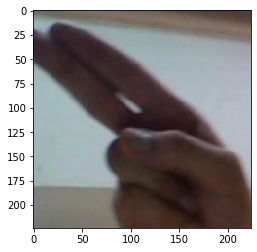

In [22]:
x, y = dataset[23421]
print(y)
imshow(x)

In [0]:
batch_size = 128
validation_split = 0.1
shuffle_dataset = True
random_seed = 19

# In order to train faster I'm going to truncate the data; this should not
# happen still long term!
# max_train_len = 10000
# max_valid_len = float.inf #1000

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [24]:
print("Number in the train sampler: {}".format(len(train_indices)))
print("Number in the validate sampler: {}".format(len(val_indices)))

Number in the train sampler: 78300
Number in the validate sampler: 8700


In [27]:
# Initialize Model
model = torchvision.models.resnet50(pretrained=True)
num_f = model.fc.in_features
model.fc = nn.Linear(num_f, 29)

model = model.cuda() #use GPU

# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.3MB/s]


In [32]:
# This is what was talked about in the video for memory management
num_epochs = 10
valid_frequency = 1

best_loss = float("inf")
saved_epoch = -1

train_losses = []
validation_losses = []
train_acc = []

def scope():
  try:
    #your code for calling dataset and dataloader
    gc.collect()
    torch.cuda.empty_cache()


    loop = tqdm(
        total=(len(train_loader) * num_epochs) +
          (len(validation_loader) * (num_epochs // valid_frequency))
        , position = 0)

    for epoch in range(num_epochs):
      sum_loss = 0
      count_loss = 0

      for x, y_truth in train_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        y_hat = model(x)
        y_long = y_truth.long()

        # print("\n\n-----------\ny_hat: {}, y_long: {}\n-----------\n\n".format(y_hat.size(), y_long.size()))
        loss = objective(y_hat, y_long)
        sum_loss += loss.item()
        count_loss += 1
        accuracy = 1- (torch.nonzero(torch.argmax(y_hat, 1) - y_truth).size(0) / len(y_truth))
        train_acc.append(accuracy)

        loop.set_description("epoch:{}, loss:{:.4f}, accuracy:{:.4f}".format(epoch, loss.item(), accuracy))
        loop.update(1)
        loss.backward()
        optimizer.step()

      epoch_loss = sum_loss / count_loss
      train_losses.append((epoch, epoch_loss))
      if epoch_loss < best_loss:
        best_loss = epoch_loss
        saved_epoch = epoch
        state = {
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict()
        }
        model_file = root_dir + "128px_{:4f}loss_20_split.mod".format(best_loss)
        torch.save(state, model_file)

      if epoch % valid_frequency == 0 and False:
        sum_loss = 0
        count_loss = 0
        with torch.no_grad():
          for x, y_truth in validation_loader:
            x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
            y_hat = model(x)
            loss = objective(y_hat, y_truth.long())
            sum_loss += loss.item()
            count_loss += 1       
          validation_losses.append((epoch, sum_loss / count_loss))
            # validation_accuracies.append([total_batch_counter, sum_acc / count])
          
    # Call your model, figure out loss and accuracy
    
  except:
    __ITB__()
    raise
    
scope()

epoch:0, loss:0.2247, accuracy:0.9375:   7%|▋         | 1868/27190 [24:44<5:34:42,  1.26it/s]

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/torch/optim/adam.py in step(self=Adam (
Parameter Group 0
    amsgrad: False
    ...  eps: 1e-08
    lr: 0.0001
    weight_decay: 0
), closure=None)
     93 
     94                 # Decay the first and second moment running average coefficient
---> 95                 exp_avg.mul_(beta1).add_(1 - beta1, grad)
        exp_avg.mul_ = <built-in method mul_ of Tensor object at 0x7f1c9cf5c318>
        beta1.add_ = undefined
        beta1 = 0.9
        grad = tensor([[[[-5.0902e-04, -5.3434e-04, -2.0472e-05],
          [-5.2168e-04, -4.5926e-04,  5.1824e-06],
          [-3.3331e-04, -3.5426e-04, -2.3439e-04]],

         [[-2.6463e-04, -3.2070e-04, -2.4145e-04],
          [-2.9007e-04, -3.5730e-04, -5.5931e-04],
          [-3.8697e-04, -3.5295e-04, -6.1265e-04]],

         [[ 3.2707e-04,  1.9598e-04,  1.

KeyboardInterrupt: ignored

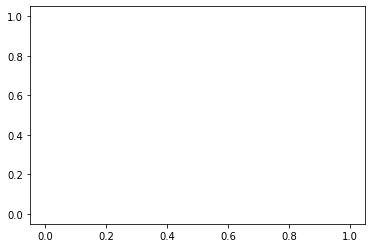

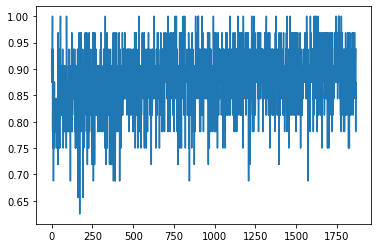

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.show()
plt.plot(train_acc)
plt.show()

In [0]:
model_file = root_dir + "128px_0.0002loss_1000_100_split.mod"
torch.save(model.state_dict(), model_file)


NameError: ignored

In [0]:
model = ConvNetwork(3, len(dataset.dataset_folder.classes), dimensions=128).cuda()
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [0]:
# !cd "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/" && unzip Photos.zip
!#mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle"
#!mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

!ls "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

IMG_20191109_203810.jpg  IMG_20191109_203816.jpg  IMG_20191109_203822.jpg
IMG_20191109_203812.jpg  IMG_20191109_203818.jpg  IMG_20191109_203824.jpg
IMG_20191109_203814.jpg  IMG_20191109_203819.jpg


In [0]:
michelle_set = ASLDataset(root_dir, "Michelle", size=128)
michelle_loader = DataLoader(michelle_set, batch_size=1)

In [0]:
len(michelle_set)

8

In [0]:
torch.argmax(torch.Tensor([10,0,2]))

tensor(0)

In [0]:
dataset.dataset_folder.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [0]:
[dataset.dataset_folder.classes[torch.argmax(model(i[0].cuda())).item()] for i in michelle_loader]

['nothing', 'S', 'S', 'nothing', 'S', 'space', 'space', 'nothing']

In [0]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [0]:
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

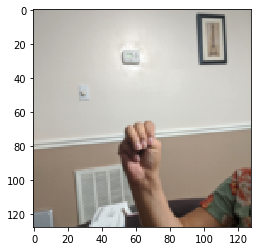

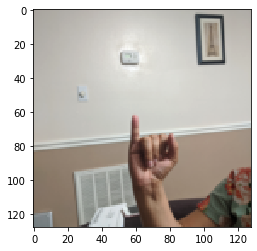

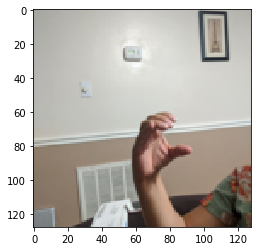

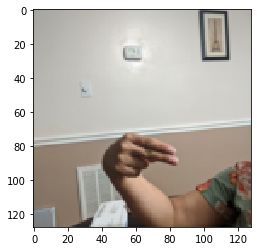

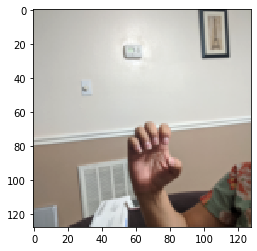

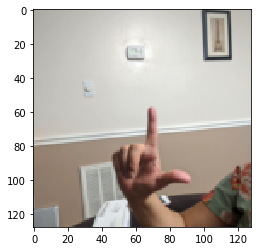

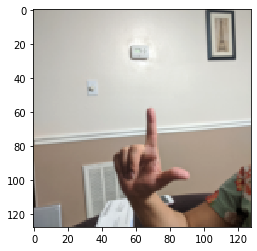

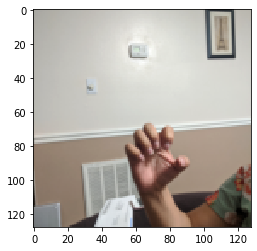

In [0]:
for x, y in michelle_loader:
  show_imgs(x)


# SSH Access

If ssh_connect is True, an ssh server will be set up on the hosting server. Ergo power.

In [0]:
ssh_connect = False
if ssh_connect:
  import random, string, getpass

  password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))
  alias = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(8))
  ! echo root:$password | chpasswd

  ! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
  ! mkdir -p /var/run/sshd
  ! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config && echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
  ! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc && echo "export LD_LIBRARY_PATH" >> /root/.bashrc
  get_ipython().system_raw('/usr/sbin/sshd -D &')

  print('sshpass -p {} ssh -o "StrictHostKeyChecking no" -J serveo.net root@{}'.format(password, alias))
  ! ssh -o "StrictHostKeyChecking no" -R $alias:22:localhost:22 serveo.net